<a href="https://colab.research.google.com/github/shohug161/Mars/blob/main/645_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Brain Tumor Classification/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Brain Tumor Classification/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:18<00:00,  4.05it/s]


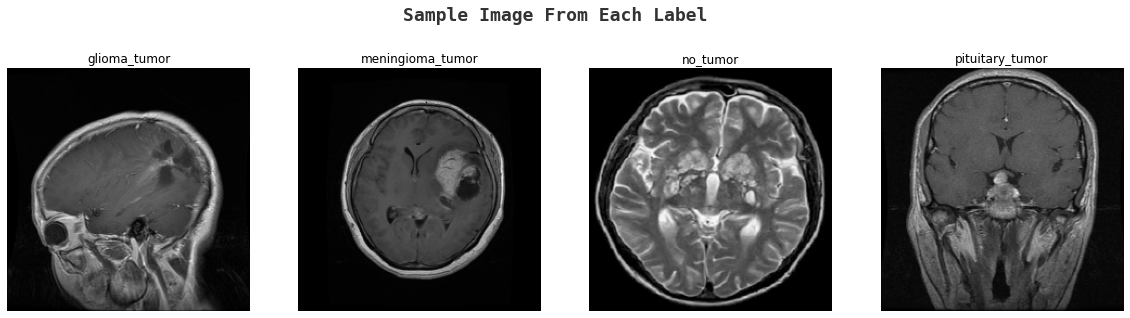

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

In [7]:
X_train.shape

(2870, 224, 224, 3)

In [8]:
X_test.shape

(394, 224, 224, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


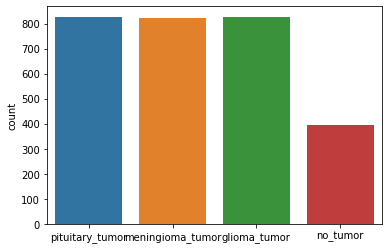

In [9]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


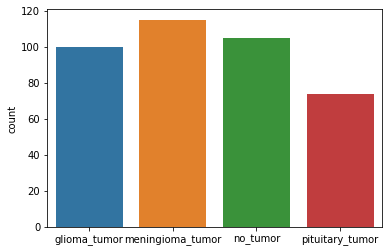

In [10]:
sns.countplot(y_test)

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

In [13]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization()) 

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35)) 

model_cnn.add(Conv2D(64, (3, 3), padding='same')) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten()) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(512)) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4)) 
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                      

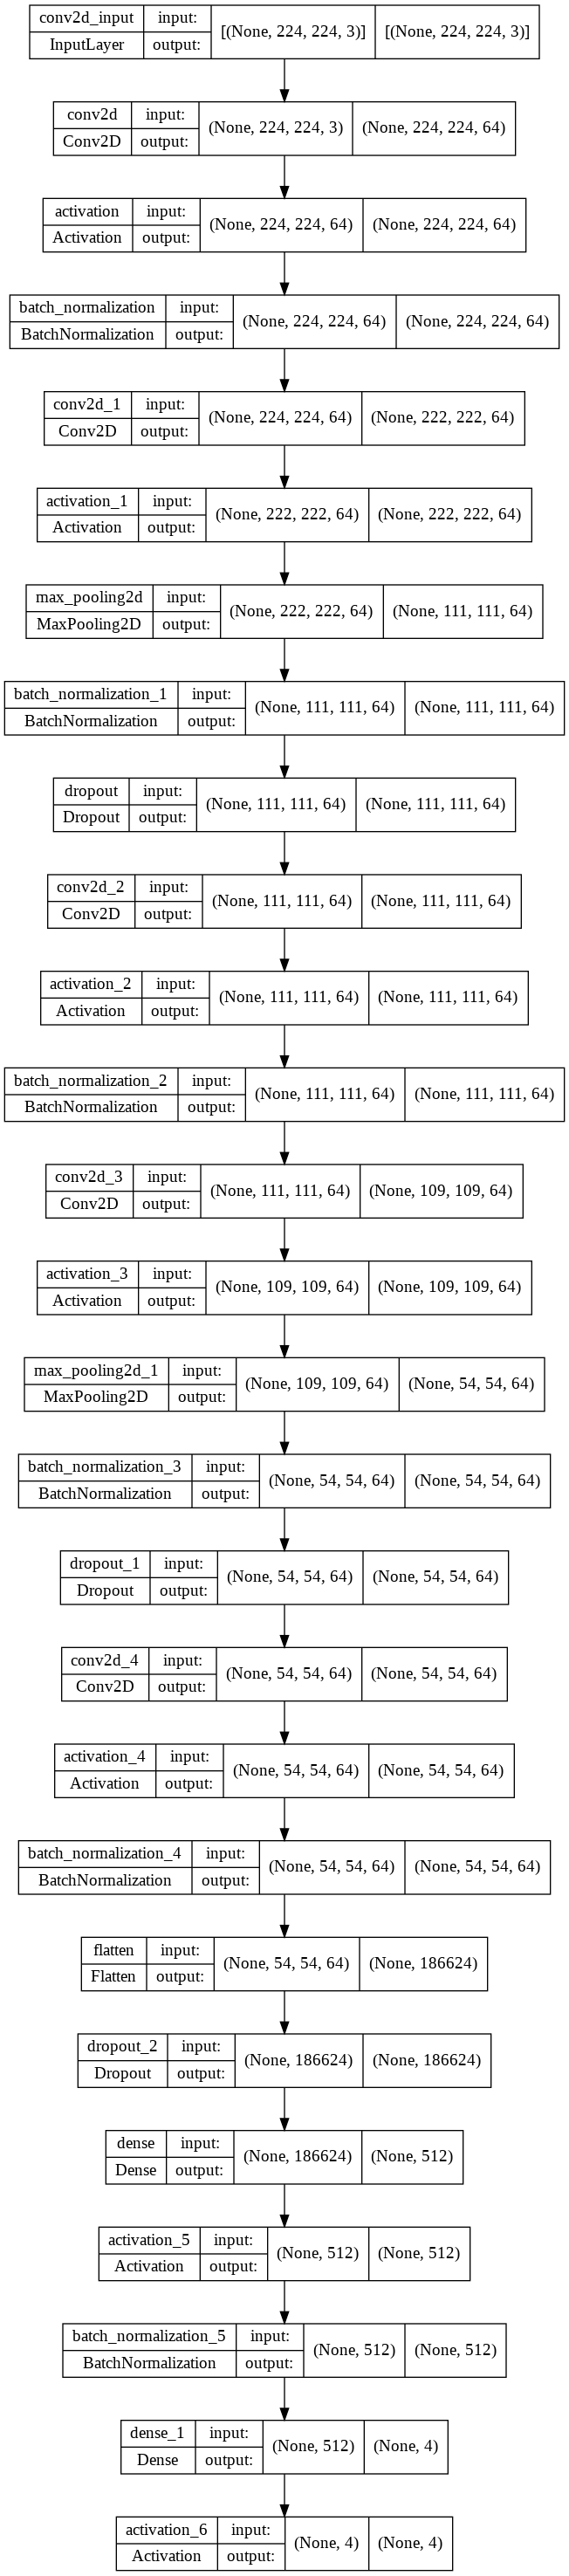

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [19]:
history = model_cnn.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 25, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/25
73/73 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.7091
Epoch 1: val_accuracy improved from -inf to 0.34749, saving model to effnet.h5
73/73 [==============================] - 74s 791ms/step - loss: 1.1029 - accuracy: 0.7091 - val_loss: 3.7859 - val_accuracy: 0.3475 - lr: 0.0010
Epoch 2/25
73/73 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.8025
Epoch 2: val_accuracy did not improve from 0.34749
73/73 [==============================] - 43s 583ms/step - loss: 0.5089 - accuracy: 0.8025 - val_loss: 10.2716 - val_accuracy: 0.1081 - lr: 0.0010
Epoch 3/25
73/73 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8903
Epoch 3: val_accuracy did not improve from 0.34749

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 [==============================] - 43s 583ms/step - loss: 0.3032 - accuracy: 0.8903 - val_loss: 10.3865 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 4/25
73/73 [=====

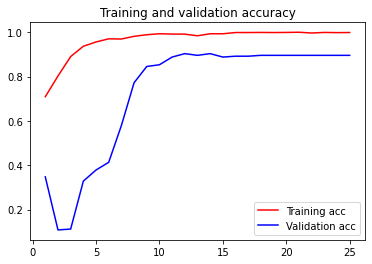

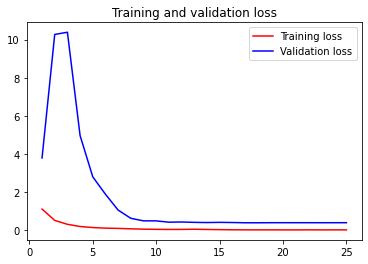

In [20]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [22]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 71.57%


In [23]:
model_cnn.evaluate(X_train, y_train)

81/81 [==============================] - 15s 190ms/step - loss: 0.0420 - accuracy: 0.9895


[0.04199650511145592, 0.9895470142364502]

In [24]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.71      0.20      0.31       100
           1       0.77      0.91      0.84       115
           2       0.63      0.94      0.76       105
           3       0.79      0.78      0.79        74

    accuracy                           0.72       394
   macro avg       0.73      0.71      0.67       394
weighted avg       0.72      0.72      0.67       394



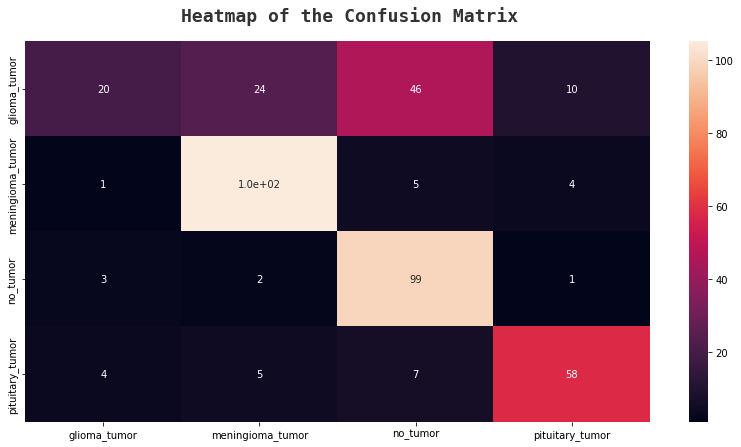

In [25]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [26]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [27]:
for layers in vgg.layers:
  layers.trainable=False

In [28]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

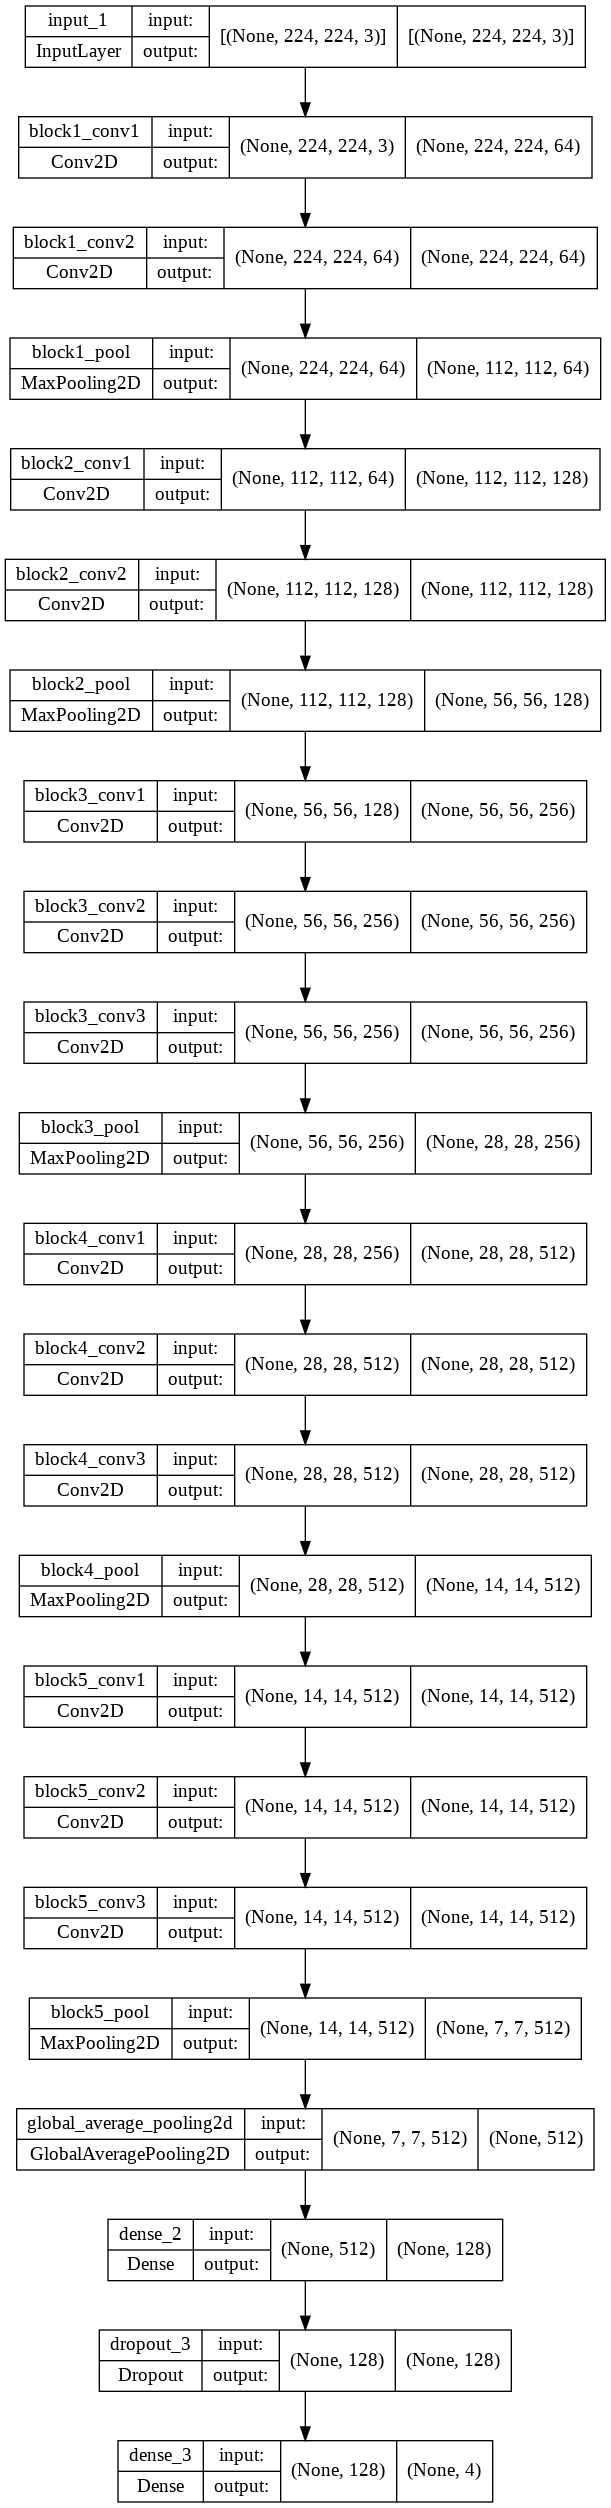

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [31]:
history = model_vgg.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 1.2331 - accuracy: 0.4540
Epoch 1: val_accuracy did not improve from 0.90347
73/73 [==============================] - 38s 446ms/step - loss: 1.2331 - accuracy: 0.4540 - val_loss: 0.9568 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 0.6454
Epoch 2: val_accuracy did not improve from 0.90347
73/73 [==============================] - 28s 387ms/step - loss: 0.9264 - accuracy: 0.6454 - val_loss: 0.7516 - val_accuracy: 0.8147 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.7367
Epoch 3: val_accuracy did not improve from 0.90347
73/73 [==============================] - 28s 384ms/step - loss: 0.7566 - accuracy: 0.7367 - val_loss: 0.6352 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7608
Epoch 4: val_accuracy did not improv

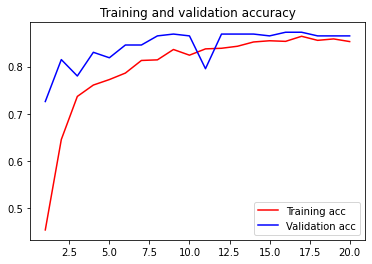

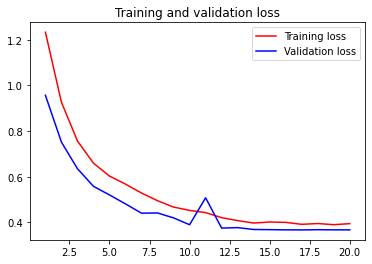

In [32]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [34]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 56.35%
